In [1]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. LOAD DATA
df = pd.read_csv("ai_job_dataset.csv")  # place dataset in same folder
print("Data shape:", df.shape)
df.head()

Data shape: (15000, 19)


,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [3]:
df.columns

Index(['job_id', 'job_title', 'salary_usd', 'salary_currency',
       'experience_level', 'employment_type', 'company_location',
       'company_size', 'employee_residence', 'remote_ratio', 'required_skills',
       'education_required', 'years_experience', 'industry', 'posting_date',
       'application_deadline', 'job_description_length', 'benefits_score',
       'company_name'],
      dtype='object')

In [4]:
# Preview the job title distribution
job_title_counts = df['job_title'].value_counts()
job_title_counts

job_title
Machine Learning Researcher    808
AI Software Engineer           784
Autonomous Systems Engineer    777
Machine Learning Engineer      772
AI Architect                   771
Head of AI                     765
NLP Engineer                   762
Robotics Engineer              759
Data Analyst                   759
AI Research Scientist          756
Data Engineer                  749
AI Product Manager             743
Research Scientist             742
Principal Data Scientist       734
AI Specialist                  728
ML Ops Engineer                725
Computer Vision Engineer       724
Data Scientist                 720
Deep Learning Engineer         718
AI Consultant                  704
Name: count, dtype: int64

In [5]:
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['job_id', 'job_title', 'salary_currency', 'experience_level',
       'employment_type', 'company_location', 'company_size',
       'employee_residence', 'required_skills', 'education_required',
       'industry', 'posting_date', 'application_deadline', 'company_name'],
      dtype='object')


In [6]:
df.isnull().sum()

job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [17]:
# 3. DATA PREPROCESSING
'''df.drop_duplicates(inplace=True)
df.dropna(subset=['job_title', 'salary_usd'], inplace=True)

# Fill missing values
df['education_required'].fillna('Unknown', inplace=True)
df['benefits_score'].fillna(df['benefits_score'].mean(), inplace=True)

"df.drop_duplicates(inplace=True)\ndf.dropna(subset=['job_title', 'salary_usd'], inplace=True)\n\n# Fill missing values\ndf['education_required'].fillna('Unknown', inplace=True)\ndf['benefits_score'].fillna(df['benefits_score'].mean(), inplace=True)"

In [9]:
# Encode target variable for classification
'''top_roles = df['job_title'].value_counts().head(10).index
df['job_title'] = df['job_title'].apply(lambda x: x if x in top_roles else 'Other')'''

#top_roles = df['job_title'].value_counts().head(10).index
#df = df[df['job_title'].isin(top_roles)].copy()

def map_job_title(title):
    if 'Engineer' in title:
        return 'Engineer'
    elif 'Scientist' in title or 'Researcher' in title:
        return 'Scientist'
    elif 'Manager' in title:
        return 'Manager'
    elif 'Analyst' in title:
        return 'Analyst'
    elif 'Consultant' in title:
        return 'Consultant'
    elif 'Head' in title or 'Architect' in title or 'Principal' in title:
        return 'Leadership'
    else:
        return 'Other'

df['job_category'] = df['job_title'].apply(map_job_title)


# Encode categorical variables
categorical_cols = ['experience_level', 'employment_type', 'company_location',
                    'employee_residence', 'education_required', 'industry', 'company_size']

df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Feature selection
features = ['remote_ratio', 'years_experience', 'job_description_length', 'benefits_score']
features += [col for col in df_encoded.columns if col.startswith(tuple(categorical_cols))]

X_class = df_encoded[features]
#y_class = df_encoded['job_title']
y_class = df['job_category']

# Encode target for regression
# REGRESSION: Predicting salary based on all relevant features, including job title (encoded)
label_enc = LabelEncoder()
df_encoded['job_title_encoded'] = label_enc.fit_transform(df['job_title'])

X_reg = df_encoded[features + ['job_title_encoded']]
y_reg = df_encoded['salary_usd']

In [10]:
# 4. TRAIN/TEST SPLIT
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [11]:
# 5. MODEL TRAINING

# CLASSIFICATION - Predicting job_title
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

# REGRESSION - Predicting salary
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(Xr_train, yr_train)
yr_pred = reg.predict(Xr_test)

Classification Accuracy: 0.42866666666666664

Classification Report:
               precision    recall  f1-score   support

     Analyst       0.00      0.00      0.00       146
  Consultant       0.00      0.00      0.00       142
    Engineer       0.44      0.93      0.60      1327
  Leadership       0.22      0.01      0.01       323
     Manager       0.00      0.00      0.00       157
       Other       0.00      0.00      0.00       144
   Scientist       0.25      0.07      0.11       761

    accuracy                           0.43      3000
   macro avg       0.13      0.14      0.10      3000
weighted avg       0.28      0.43      0.29      3000



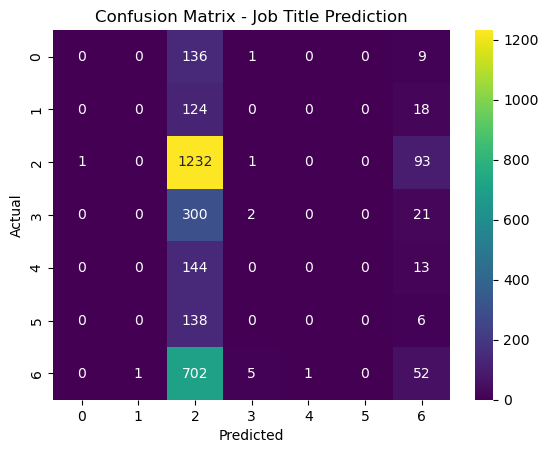


Regression R² Score: 0.8734064588107209
MAE: 15304.558083333333
RMSE: 21487.449962977505


In [12]:
# 6. EVALUATION

# CLASSIFICATION REPORT
print("Classification Accuracy:", accuracy_score(yc_test, yc_pred))
print("\nClassification Report:\n", classification_report(yc_test, yc_pred))
conf_mat = confusion_matrix(yc_test, yc_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.title("Confusion Matrix - Job Title Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# REGRESSION REPORT
print("\nRegression R² Score:", r2_score(yr_test, yr_pred))
print("MAE:", mean_absolute_error(yr_test, yr_pred))
print("RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred)))

In [13]:
# 7. SAVE MODELS
'''with open("job_title_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)

with open("salary_predictor.pkl", "wb") as f:
    pickle.dump(reg, f)'''

'with open("job_title_classifier.pkl", "wb") as f:\n    pickle.dump(clf, f)\n\nwith open("salary_predictor.pkl", "wb") as f:\n    pickle.dump(reg, f)'

In [34]:
# 8. SAMPLE PREDICTION
# Use a random row from test set
sample_input = Xc_test.sample(1)
print("Predicted Job Title:", clf.predict(sample_input)[0])

sample_input_r = Xr_test.sample(1)
print("Predicted Salary (USD):", reg.predict(sample_input_r)[0])

Predicted Job Title: Scientist
Predicted Salary (USD): 141585.52
